In [1]:
import torch
import torch_geometric
from torch_geometric import utils
from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
ec_hic = np.load('data/GBM39ec_5k_collapsed_matrix.npy')
hsr_hic = np.load('data/GBM39HSR_5k_collapsed_matrix.npy')

In [3]:
ec_df = pd.read_csv('data/ec_cleaned.csv')
hsr_df = pd.read_csv('data/hsr_cleaned.csv')

In [4]:
hsr_feats = torch.tensor(hsr_df[['read_count', 'total_genes']].to_numpy())
hsr_labels = torch.zeros(hsr_feats.shape[0])

ec_feats = torch.tensor(ec_df[['read_count', 'total_genes']].to_numpy())
ec_labels = torch.ones(ec_feats.shape[0])

In [5]:
def hic_to_sparse(hic_mat):
    adj_mat = np.triu(hic_mat)
    sparse_adj = coo_matrix(adj_mat)

    return utils.from_scipy_sparse_matrix(sparse_adj)

In [6]:
hsr_edge_index, hsr_edge_attr = hic_to_sparse(hsr_hic)
hsr_graph = torch_geometric.data.Data(edge_index = hsr_edge_index, edge_attr = hsr_edge_attr, x = hsr_feats, y = hsr_labels)

ec_edge_index, ec_edge_attr = hic_to_sparse(ec_hic)
ec_graph = torch_geometric.data.Data(edge_index = ec_edge_index, edge_attr = ec_edge_attr, x = ec_feats, y = ec_labels)

In [7]:
x = torch.cat([ec_feats, hsr_feats], dim=0)
hsr_edge_index = hsr_edge_index + ec_labels.shape[0]
edge_index = torch.cat([ec_edge_index, hsr_edge_index], dim=1)
edge_attr = torch.cat([ec_edge_attr, hsr_edge_attr], dim=0)
labels = torch.cat([ec_labels, hsr_labels], dim=0)

G = torch_geometric.data.Data(edge_index = edge_index, edge_attr = edge_attr, x = x, y = labels)

In [8]:
from torch_geometric.nn.models import Node2Vec

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
def train_one_epoch(node2vec, optimizer, loader):
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def train_node2vec(G, n_epochs=100):
    node2vec = Node2Vec(edge_index=G.edge_index, embedding_dim=32, walk_length=3, context_size=2, walks_per_node=50, num_negative_samples=1, sparse=True)
    node2vec = node2vec.to(device)
    G = G.to(device)
    
    loader = node2vec.loader(batch_size=128, shuffle=True)
    optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

    for epoch in range(1, n_epochs+1):
        loss = train_one_epoch(node2vec, optimizer=optimizer, loader=loader)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}')

    node2vec.eval()
    return node2vec().detach().cpu()

In [22]:
embeds = train_node2vec(G, n_epochs=200)

Epoch: 1, Loss: 4.5821
Epoch: 2, Loss: 4.3793
Epoch: 3, Loss: 4.1563
Epoch: 4, Loss: 3.9664
Epoch: 5, Loss: 3.7798
Epoch: 6, Loss: 3.6325
Epoch: 7, Loss: 3.4565
Epoch: 8, Loss: 3.2980
Epoch: 9, Loss: 3.1551
Epoch: 10, Loss: 3.0124
Epoch: 11, Loss: 2.8660
Epoch: 12, Loss: 2.7858
Epoch: 13, Loss: 2.6462
Epoch: 14, Loss: 2.5546
Epoch: 15, Loss: 2.4308
Epoch: 16, Loss: 2.3123
Epoch: 17, Loss: 2.2298
Epoch: 18, Loss: 2.1551
Epoch: 19, Loss: 2.0612
Epoch: 20, Loss: 1.9808
Epoch: 21, Loss: 1.9144
Epoch: 22, Loss: 1.8474
Epoch: 23, Loss: 1.7873
Epoch: 24, Loss: 1.7440
Epoch: 25, Loss: 1.6853
Epoch: 26, Loss: 1.6336
Epoch: 27, Loss: 1.5979
Epoch: 28, Loss: 1.5439
Epoch: 29, Loss: 1.5133
Epoch: 30, Loss: 1.4926
Epoch: 31, Loss: 1.4496
Epoch: 32, Loss: 1.4171
Epoch: 33, Loss: 1.3941
Epoch: 34, Loss: 1.3842
Epoch: 35, Loss: 1.3599
Epoch: 36, Loss: 1.3417
Epoch: 37, Loss: 1.3131
Epoch: 38, Loss: 1.3079
Epoch: 39, Loss: 1.2958
Epoch: 40, Loss: 1.2755
Epoch: 41, Loss: 1.2595
Epoch: 42, Loss: 1.2541
E

In [16]:
feats_and_embeds = torch.cat([embeds, x], dim=1)

In [17]:
X = feats_and_embeds.numpy()
y = G.y.cpu().numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
mdl = LogisticRegression(solver='liblinear')
mdl.fit(X_train, y_train)

preds = mdl.predict(X_test)
(preds == y_test).mean()

1.0

In [18]:
ec_embeds = train_node2vec(ec_graph)
hsr_embeds = train_node2vec(hsr_graph)

Epoch: 1, Loss: 4.2963
Epoch: 2, Loss: 4.1858
Epoch: 3, Loss: 4.0192
Epoch: 4, Loss: 3.9084
Epoch: 5, Loss: 3.6877
Epoch: 6, Loss: 3.6246
Epoch: 7, Loss: 3.4693
Epoch: 8, Loss: 3.3091
Epoch: 9, Loss: 3.2495
Epoch: 10, Loss: 3.1299
Epoch: 11, Loss: 3.0182
Epoch: 12, Loss: 2.9003
Epoch: 13, Loss: 2.8697
Epoch: 14, Loss: 2.7925
Epoch: 15, Loss: 2.6898
Epoch: 16, Loss: 2.5917
Epoch: 17, Loss: 2.5253
Epoch: 18, Loss: 2.4218
Epoch: 19, Loss: 2.3816
Epoch: 20, Loss: 2.3169
Epoch: 21, Loss: 2.2480
Epoch: 22, Loss: 2.1832
Epoch: 23, Loss: 2.1292
Epoch: 24, Loss: 2.0477
Epoch: 25, Loss: 2.0285
Epoch: 26, Loss: 1.9595
Epoch: 27, Loss: 1.9270
Epoch: 28, Loss: 1.8628
Epoch: 29, Loss: 1.8251
Epoch: 30, Loss: 1.8033
Epoch: 31, Loss: 1.7458
Epoch: 32, Loss: 1.7083
Epoch: 33, Loss: 1.6839
Epoch: 34, Loss: 1.6561
Epoch: 35, Loss: 1.6121
Epoch: 36, Loss: 1.6015
Epoch: 37, Loss: 1.5618
Epoch: 38, Loss: 1.5331
Epoch: 39, Loss: 1.5088
Epoch: 40, Loss: 1.4766
Epoch: 41, Loss: 1.4504
Epoch: 42, Loss: 1.4478
E

In [69]:
standard_ec_embed = ec_embeds #(ec_embeds - ec_embeds.mean(0)) / ec_embeds.std(0)
standard_hsr_embed = hsr_embeds #(hsr_embeds - hsr_embeds.mean(0)) / hsr_embeds.std(0)

embeds = torch.cat([standard_ec_embed, standard_hsr_embed], dim=0)
feats_and_embeds = torch.cat([embeds, x], dim=1)

In [70]:
X = feats_and_embeds.numpy()
y = torch.cat([ec_labels, hsr_labels], dim=0).numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
mdl = LogisticRegression(solver='liblinear')
mdl.fit(X_train, y_train)

preds = mdl.predict(X_test)
(preds == y_test).mean()

0.504950495049505

In [72]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=63,
    learning_rate=0.1,
    n_estimators=500
)

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

y_pred

[LightGBM] [Info] Number of positive: 202, number of negative: 199
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4425
[LightGBM] [Info] Number of data points in the train set: 401, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503741 -> initscore=0.014963
[LightGBM] [Info] Start training from score 0.014963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

array([0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

In [74]:
(y_pred == y_test).mean()

0.801980198019802

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

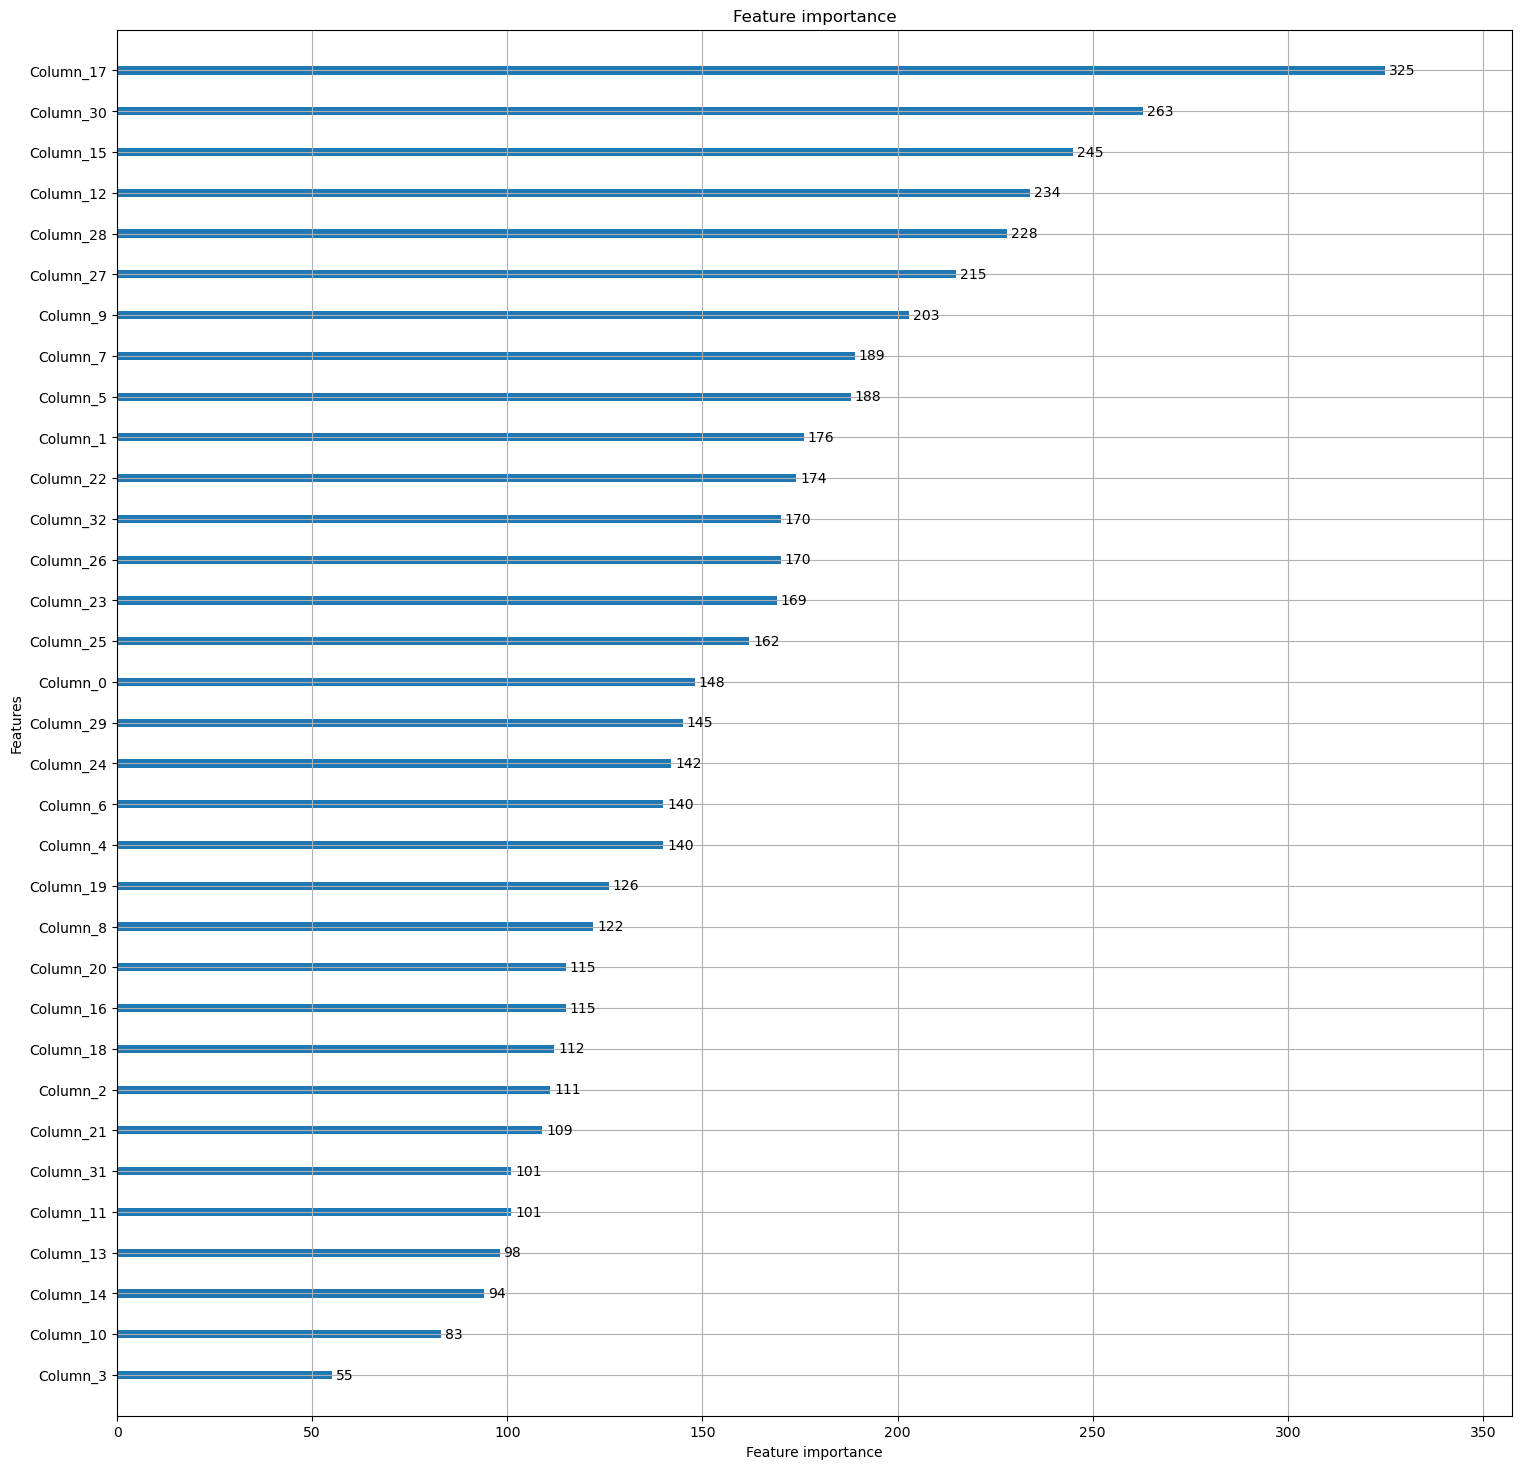

In [75]:
from lightgbm import plot_importance

plot_importance(lgb, figsize=(18, 18))

In [91]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=32,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)

y_preds = xgb.predict(X_test)

/home/vdubey/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:45:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [92]:
(y_test == y_preds).mean()

0.7623762376237624